In [98]:
import numpy as np
import pandas as pd

In [99]:
df = pd.read_csv('/Users/donavanrooi/Desktop/Data Science/Datasets/diabetes_012_health_indicators_BRFSS2015.csv')

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [101]:
# Separate features (X) and target variable (y)
# here the least informative features are already removed, they were identified using LASSO
X = df.drop(['Diabetes_012', "Fruits", "Veggies", "PhysActivity", "AnyHealthcare", "NoDocbcCost", "MentHlth", "PhysHlth", "Smoker"], axis=1)
y = df['Diabetes_012']

In [102]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

#The dataset is split into training and testing sets, with 20% of the data reserved for testing and 80% for training, 
# while random_state=42 ensures the split is reproducible each time the code is executed.

In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
# Scale numeric features only, this is also called z-standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This process ensures that both the training and test datasets are standardized, meaning the features across both sets have similar scales. Each feature is adjusted so that its values are centered around zero and scaled to have a consistent spread, 
# resulting in a zero mean and a variance of one.

In [105]:
from sklearn.utils.class_weight import compute_sample_weight

In [106]:
# Calculate sample weights, inversely proportional to class frequencies
sample_weights = compute_sample_weight(
    class_weight='balanced', # 'balanced' automatically computes inverse weights
    y=y_train
)

In [119]:
model = LogisticRegression(solver='saga', random_state=42)

In [120]:
import sklearn
sklearn.set_config(enable_metadata_routing=True)

In [121]:
configured_estimator = model.set_fit_request(sample_weight=True)

In [122]:
ovr_wrapper_model = OneVsRestClassifier(configured_estimator)

In [123]:
ovr_wrapper_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",LogisticRegre...solver='saga')
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=

In [124]:
class_labels = ovr_wrapper_model.classes_
print(f"Classes: {class_labels}")

Classes: [0. 1. 2.]


In [125]:
predictions = ovr_wrapper_model.predict(X_test_scaled)

In [126]:
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.69      0.80     53426
         1.0       0.03      0.24      0.06      1158
         2.0       0.35      0.62      0.44      8836

    accuracy                           0.67     63420
   macro avg       0.44      0.52      0.43     63420
weighted avg       0.85      0.67      0.73     63420



In [115]:
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.67


In [116]:
# As this is a classification problem we use these metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix Array:
[[36775  6817  9834]
 [  337   282   539]
 [ 1729  1643  5464]]


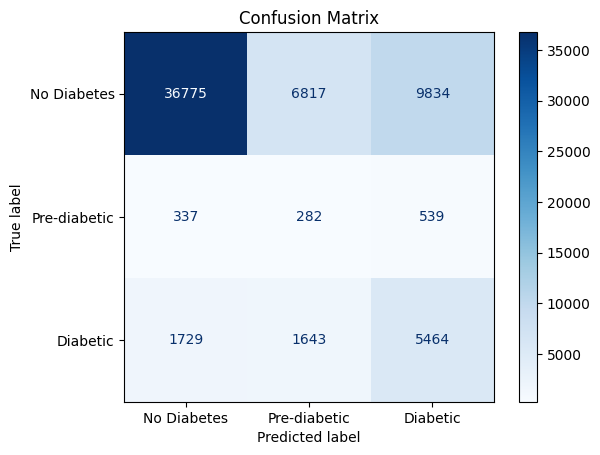

In [117]:
# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)
print(f"Confusion Matrix Array:\n{cm}")

# 2. Visualize the confusion matrix with labels
# Use ConfusionMatrixDisplay for an easy-to-read plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Pre-diabetic", "Diabetic"])

# Plot the figure
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

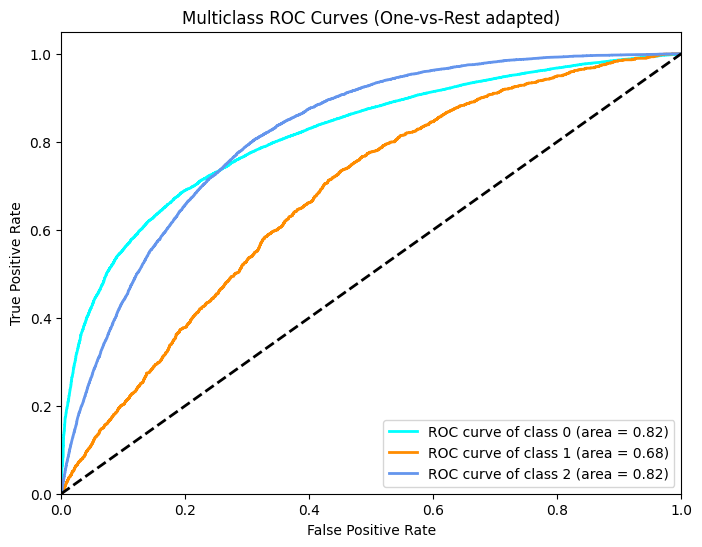

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# Note: The base estimator must support 'predict_proba' or 'decision_function'
# LinearSVC does not support predict_proba by default. We can use an SVC with probability=True
# or another classifier like Logistic Regression.
# This example uses a base Logistic Regression for probability outputs.

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier # OvR is often used for ROC curves visualization

# Binarize the output labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

y_score = ovr_wrapper_model.decision_function(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-Rest adapted)')
plt.legend(loc="lower right")
plt.show()


# Switching over to one versus one

In [128]:
from sklearn.multiclass import OneVsOneClassifier

In [133]:
ovo_model = OneVsOneClassifier(configured_estimator)

In [138]:
print("Training OneVsOne Logistic Regression model...")
ovo_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print("Training complete.")

Training OneVsOne Logistic Regression model...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training complete.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [139]:
y_pred = ovo_model.predict(X_test_scaled)

In [141]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6446


In [142]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     53426
         1.0       0.03      0.30      0.06      1158
         2.0       0.36      0.60      0.44      8836

    accuracy                           0.64     63420
   macro avg       0.45      0.52      0.43     63420
weighted avg       0.85      0.64      0.72     63420



Confusion Matrix Array:
[[35272  9102  9052]
 [  306   350   502]
 [ 1491  2086  5259]]


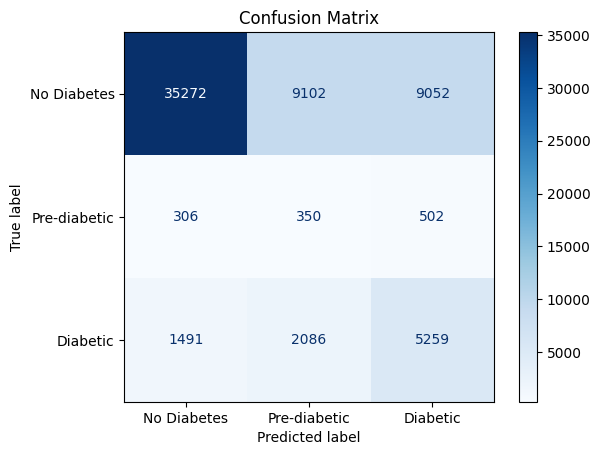

In [143]:
# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix Array:\n{cm}")

# 2. Visualize the confusion matrix with labels
# Use ConfusionMatrixDisplay for an easy-to-read plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Pre-diabetic", "Diabetic"])

# Plot the figure
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

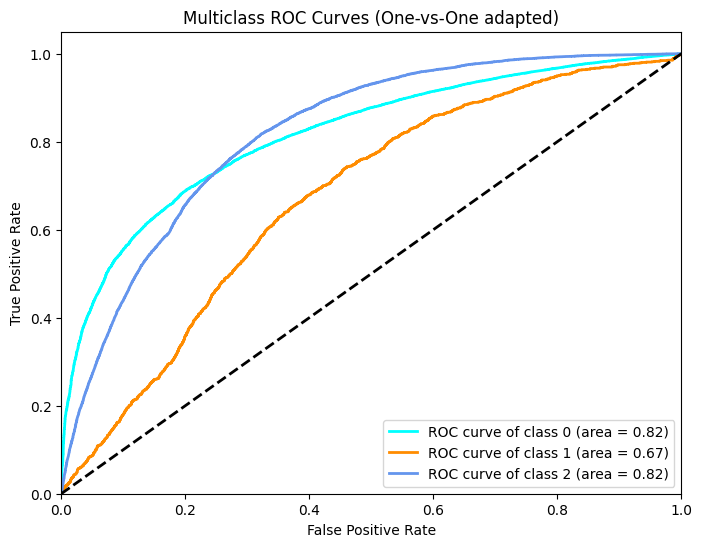

In [157]:
# Binarize the output labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

y_score = ovo_model.decision_function(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-One adapted)')
plt.legend(loc="lower right")
plt.show()